In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using TwoFAST, LaTeXStrings, LsqFit

In [3]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, 
  N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)#, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)

l_si, l_b, l_a = -2.000246241992202 , -16.8063028181858 , 0.10579360446741463
r_si, r_b, r_a = -3.5560223317289585 , -18473.820260668403 , 2.3565947984897884e-10
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "file_pk.txt"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001343431 Mpc/h_0
# 	 comoving s_max = 571.7022420911966 Mpc/h_0
# 	 comoving s_eff = 435.37470960794167 Mpc/h_0
# 	 comoving z_eff = 0.15045636097417317 
# 	 Volume of the survey V_survey = 3.845366169354268e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
tab_pk = readdlm("file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [5]:
tab_casto_Is = readdlm("tab_xi.txt", comments=true);
casto_ss = convert(Vector{Float64}, tab_casto_Is[2:end,1]);
ss = casto_ss;

In [6]:
my_I00s = [cosmo.tools.I00(s) for s in ss];
my_I20s = [cosmo.tools.I20(s) for s in ss];
my_I40s = [cosmo.tools.I40(s) for s in ss];
my_I02s = [cosmo.tools.I02(s) for s in ss];
my_I22s = [cosmo.tools.I22(s) for s in ss];
my_I31s = [cosmo.tools.I31(s) for s in ss];
my_I13s = [cosmo.tools.I13(s) for s in ss];
my_I11s = [cosmo.tools.I11(s) for s in ss];

In [7]:
#=
function I_l_n(s, PK; l=0, n=0, en = 1e6, kwargs...)
    first = quadgk(q -> en * (sphericalbesselj(l, s*q) - 1) * PK(q) * q^2 / (2 * π^2 * (q*s)^n), 
        kmin, kmax; kwargs...)
    second = quadgk(q -> en * PK(q) * q^2 / (2 * π^2 * (q*s)^n), 
        kmin, kmax; kwargs...)
    return ((first[1] + second[1]) / en, first[2]/en)
end
=#

In [8]:
#=
true_I00s = [I_l_n(s, PK; l=0, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I20s = [I_l_n(s, PK; l=2, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I40s = [I_l_n(s, PK; l=4, n=0, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I02s = [I_l_n(s, PK; l=0, n=2, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I22s = [I_l_n(s, PK; l=2, n=2, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I31s = [I_l_n(s, PK; l=3, n=1, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I13s = [I_l_n(s, PK; l=1, n=3, atol=1e-6, rtol=1e-3)[1] for s in ss];
true_I11s = [I_l_n(s, PK; l=1, n=1, atol=1e-6, rtol=1e-3)[1] for s in ss];
=#

In [9]:
casto_I00s = convert(Vector{Float64}, tab_casto_Is[2:end,2]);
casto_I20s = convert(Vector{Float64}, tab_casto_Is[2:end,3]);
casto_I40s = convert(Vector{Float64}, tab_casto_Is[2:end,4]);
casto_I02s = convert(Vector{Float64}, tab_casto_Is[2:end,5]) ./ casto_ss .^2;
casto_I22s = convert(Vector{Float64}, tab_casto_Is[2:end,6]) ./ casto_ss .^2;
casto_I31s = convert(Vector{Float64}, tab_casto_Is[2:end,7]) ./ casto_ss;
casto_I11s = convert(Vector{Float64}, tab_casto_Is[2:end,8]) ./ casto_ss;

In [10]:
my_vec = [my_I00s, my_I20s, my_I40s, my_I02s, my_I22s, my_I31s,
             my_I11s, my_I13s];
casto_vec = [casto_I00s, casto_I20s, casto_I40s, casto_I02s, casto_I22s, 
            casto_I31s, casto_I11s ];

#true_vec = [true_I00s, true_I20s, true_I40s, true_I02s, true_I22s, true_I31s,
#            true_I13s, true_I11s, true_I13s];

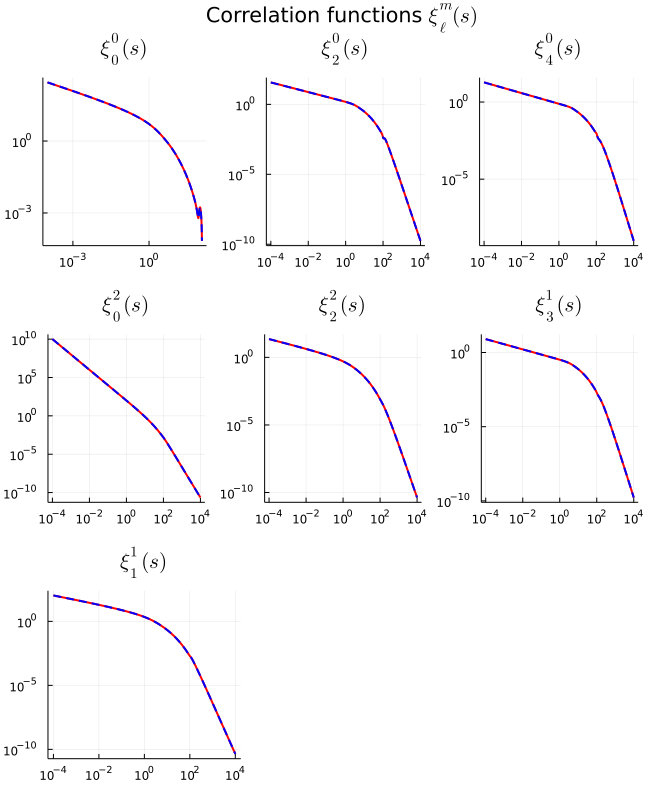

In [11]:
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)
xs = ss
for i in 1:7
    c_ys = casto_vec[i]
    m_ys = my_vec[i]
    #t_ys = true_vec[i]
    ps[i] = plot(
        [xs[c_ys.>0], xs[m_ys.>0]], #, xs[t_ys.>0]], 
        [c_ys[c_ys.>0], m_ys[m_ys.>0]],#,  t_ys[t_ys.>0]], 
        lw=2, lc=["red" "blue"], ls=[:solid :dash],
        title=ξs_names[i], legend=false,
        xaxis=:log, yaxis=:log)
end

l = @layout [A{0.05h}; a b c ; d e f; g _ _ ]
plot(title, ps..., layout=l, size=(650,800))

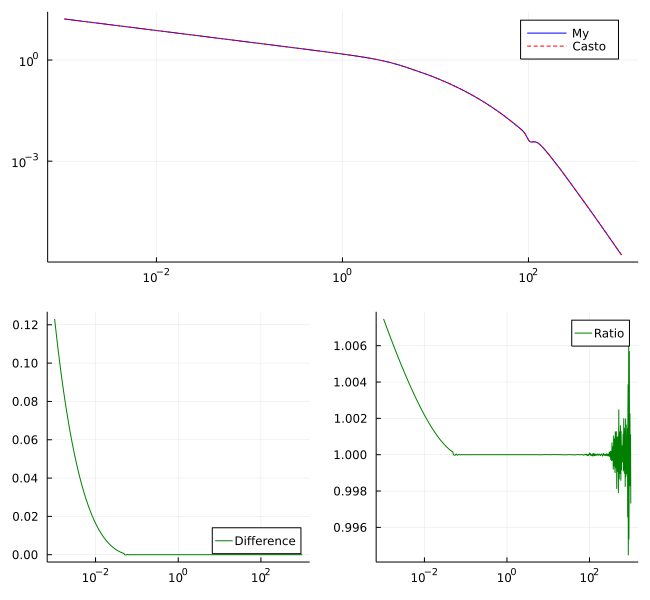

In [38]:
ind = 2

x_min = ss[findfirst(x -> x>1e-3, ss)]
x_max = ss[findfirst(x -> x>1e3, ss)]

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

p1 = plot([new_ss, new_ss], [my_ys, casto_ys], 
    xscale=:log10, yscale=:log10,
    label=["My" "Casto"], lc=[:blue :red], ls=[:solid :dash])
p2 = plot(new_ss, casto_ys .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(new_ss, casto_ys ./ my_ys, label="Ratio", lc=:green, xaxis=:log )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )